### DTM and NER combi.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/

Mounted at /content/drive
MyDrive


**Text fett markieren**# Ner bert

In [ ]:
!pip install pandas
!pip install spacy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [ ]:
import nltk
import spacy
from collections import Counter
import pandas as pd
import ast
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:

path_to_df = '/content/drive/MyDrive/Colab Notebooks/ner_predictions_with_categories3.csv'
df = pd.read_csv(path_to_df)

df_subset = df[df['Category'] != 'No Entity']

## I decided later to adjust the Topic category names and also add the average class sharefor the topic/entity plot!


print(df_subset.head())

# Some renaming and aligning of names (with updated cluster names)
df_subset['Topic Category'] = df_subset['Topic Category'].replace({
    "Mining communities": "Mining affected communities",
    "State role in mining": "Politics in mining & energy",
    "Transition Politics": "Transition politics"

})

print(df_subset.head(10))

# Topic cluster share (calculated from the dtm model output)
topic_category_shares = {
    "Mining industry": 0.2255,
    "Transition politics": 0.1846,
    "Mining affected communities": 0.1355,
    "Energy crisis": 0.1527,
    "Politics in mining & energy": 0.3017
}

# adding the respective column to the dtaframe
df_subset['Topic Category Shares'] = df_subset['Topic Category'].map(topic_category_shares)

print(df_subset.head())


                                             Sentence  \
1   Environmental groups rejected the dominance of...   
15  The problem of relying upon these actors to sa...   
16  The problem of relying upon these actors to sa...   
18  If Zuma aims, therefore, to persuade the world...   
20  The cuts promised by Sonjica just before Copen...   

                           Dominant Topic  Year  Month            Entity  \
1                            Eskom crisis  2010      1             Eskom   
15  Transition politics & climate finance  2010      1             Eskom   
16  Transition politics & climate finance  2010      1               ANC   
18  Transition politics & climate finance  2010      1        Jacob Zuma   
20  Transition politics & climate finance  2010      1  Earthlife Africa   

      Type   Category       Topic Category Broad Category  
1      ORG      Eskom        Energy crisis          Eskom  
15     ORG      Eskom  Transition Politics          Eskom  
16     ORG  Politica

<ipython-input-16-fd0ed67533d1>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Topic Category'] = df_subset['Topic Category'].replace({
<ipython-input-16-fd0ed67533d1>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Topic Category Shares'] = df_subset['Topic Category'].map(topic_category_shares)


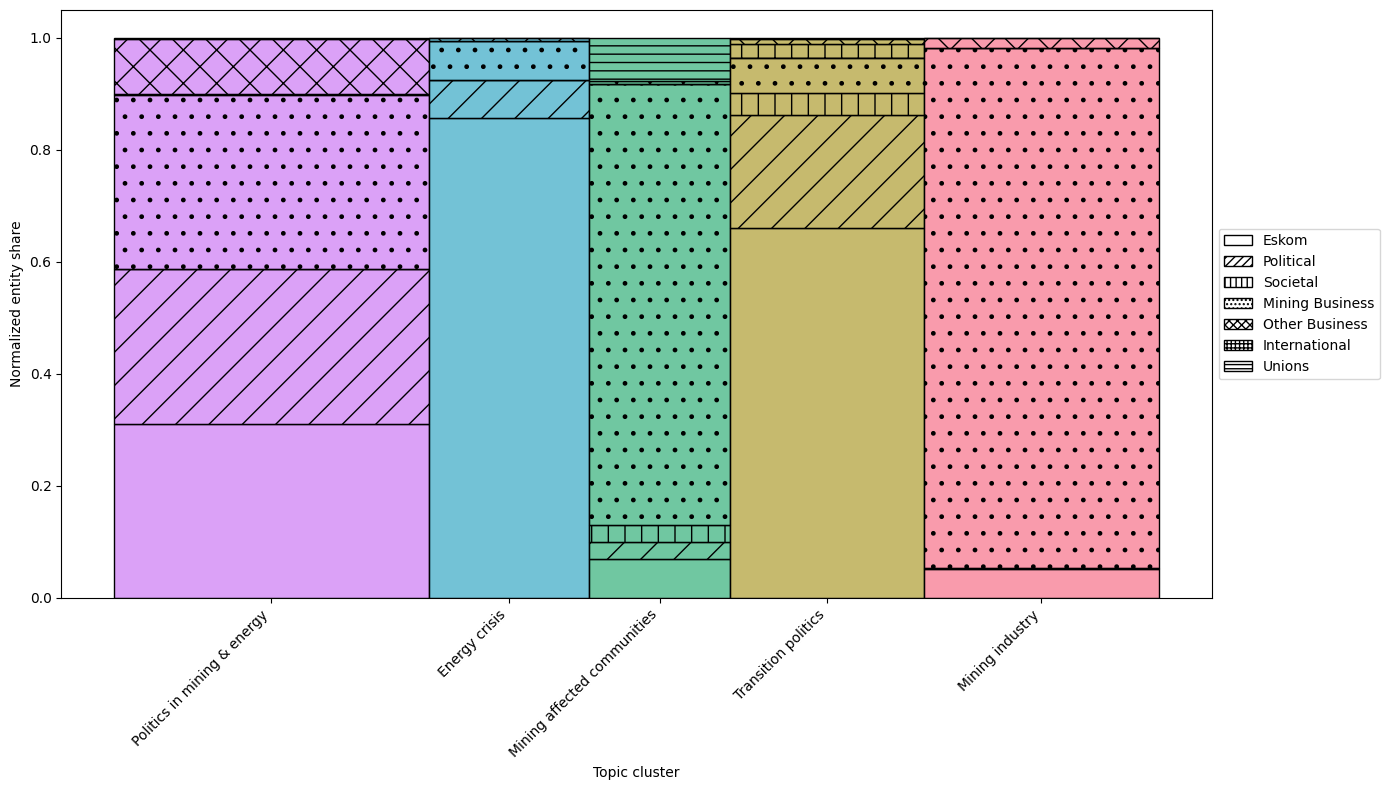

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch

path_to_df = '/content/drive/MyDrive/Colab Notebooks/ner_predictions_with_categories3.csv'
df = pd.read_csv(path_to_df)

# filter out 'no entity"
df_subset = df[df['Category'] != 'No Entity'].copy()

# Some renaming and aligning of names (with updated cluster names)
df_subset.loc[:, 'Topic Category'] = df_subset['Topic Category'].replace({
    "Mining communities": "Mining affected communities",
    "State role in mining": "Politics in mining & energy",
    "Transition Politics": "Transition politics"

})

# Topic cluster share (calculated from the dtm model output)
class_shares = {
    "Mining industry": 0.2255,
    "Transition politics": 0.1846,
    "Mining affected communities": 0.1355,
    "Energy crisis": 0.1527,
    "Politics in mining & energy": 0.3017
}

# adding the respective column to the dtaframe
df_subset.loc[:, 'Class Share'] = df_subset['Topic Category'].map(class_shares)

# mormalize entity/actor shares within each topic cluster
df_subset.loc[:, 'Entity Count'] = df_subset.groupby(['Topic Category', 'Category'])['Sentence'].transform('count')
df_subset.loc[:, 'Normalized Entity Share'] = df_subset['Entity Count'] / df_subset.groupby('Topic Category')['Entity Count'].transform('sum')

categories = df_subset['Category'].unique()
topic_categories = df_subset['Topic Category'].unique()

# custom order for the topic categories
custom_order = [
    "Politics in mining & energy",
    "Energy crisis",
    "Mining affected communities",
    "Transition politics",
    "Mining industry"
]

# colors
class_colors = sns.color_palette("husl", len(class_shares))
class_colors_with_alpha = [(r, g, b, 0.7) for r, g, b in class_colors]  # Add alpha transparency
class_color_map = {cls: color for cls, color in zip(class_shares.keys(), class_colors_with_alpha)}

#patterns
entity_patterns = {
    "Eskom": "",
    "Political": "/",
    "Societal": "|",
    "Mining Business": ".",
    "Other Business": "x",
    "International": "+",
    "Unions": "--"
}

# pattern for legend has to be denser, othersie don't see
legend_entity_patterns = {
    "Eskom": "",
    "Political": "////",
    "Societal": "|||",
    "Mining Business": "....",
    "Other Business": "xxxx",
    "International": "++++",
    "Unions": "----"
}

fig, ax = plt.subplots(figsize=(14, 8))

added_labels = set()

# Area for each cateogry
left = 0  # Starting position of the first bar
for topic_category in custom_order:
    class_share = class_shares[topic_category]  # Width of the bar
    bottom = 0
    for category in categories:
        entity_share = df_subset[(df_subset['Topic Category'] == topic_category) & (df_subset['Category'] == category)]['Normalized Entity Share'].sum()
        if entity_share > 0:
            label = category if category not in added_labels else "_nolegend_"
            ax.bar(
                left + class_share / 2, entity_share, width=class_share, bottom=bottom,
                color=class_color_map[topic_category], edgecolor="black", hatch=entity_patterns.get(category, ""),
                align='center', label=label
            )
            bottom += entity_share
            added_labels.add(category)
    left += class_share

ax.set_xlabel('Topic cluster')
ax.set_ylabel('Normalized entity share')
#ax.set_title('Topic Category Shares with Entity Category Patterns')

# X-ticks
x_ticks = np.cumsum([0] + [class_shares[tc] for tc in custom_order[:-1]]) + np.array([class_shares[tc] / 2 for tc in custom_order])
ax.set_xticks(x_ticks)
ax.set_xticklabels(custom_order, rotation=45, ha='right')

# Legend
legend_handles = [Patch(facecolor='white', edgecolor='black', hatch=legend_entity_patterns[category], label=category) for category in legend_entity_patterns]
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.show()


In [ ]:
df_subset.head(20)


,Sentence,Dominant Topic,Year,Month,Entity,Type,Category,Topic Category,Broad Category,Class Share,Entity Count,Normalized Entity Share
1,Environmental groups rejected the dominance of...,Eskom crisis,2010,1,Eskom,ORG,Eskom,Energy crisis,Eskom,0.1527,1251,0.000686
15,The problem of relying upon these actors to sa...,Transition politics & climate finance,2010,1,Eskom,ORG,Eskom,Transition politics,Eskom,0.1846,746,0.000885
16,The problem of relying upon these actors to sa...,Transition politics & climate finance,2010,1,ANC,ORG,Political,Transition politics,Political,0.1846,413,0.000490
18,"If Zuma aims, therefore, to persuade the world...",Transition politics & climate finance,2010,1,Jacob Zuma,PERSON,Political,Transition politics,Political,0.1846,413,0.000490
20,The cuts promised by Sonjica just before Copen...,Transition politics & climate finance,2010,1,Earthlife Africa,ORG,Societal,Transition politics,Societal,0.1846,181,0.000215
22,"In reality, cuts promised in the Long-Term Mit...",Transition politics & climate finance,2010,1,Sasol,ORG,Mining Business,Transition politics,Business,0.1846,229,0.000272
23,As the Eskom tariff hearings organised by the ...,Transition politics & climate finance,2010,1,Eskom,ORG,Eskom,Transition politics,Eskom,0.1846,746,0.000885
24,Yet the purpose of the new build programme is ...,Transition politics & climate finance,2010,1,Eskom,ORG,Eskom,Transition politics,Eskom,0.1846,746,0.000885
30,The department called this month for public co...,Anti-mining activism,2010,1,Eskom,ORG,Eskom,Mining affected communities,Eskom,0.1355,240,0.000294
31,Several mines are expected to be developed in ...,Anti-mining activism,2010,1,Eskom,ORG,Eskom,Mining affected communities,Eskom,0.1355,240,0.000294
